## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

### Dataset

Udacity provides it to paid access, however, you can download it on my GitHub. [Here](https://github.com/FabricioDataCardoso/A-B-Testing/) 

<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  I particuarly love this topic.

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, Let's read in the `ab_data.csv` data. Store it in `df`. 


In [6]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Checking number of rows and columns in the dataset.

In [7]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [8]:
df['user_id'].nunique()


290584

d. The proportion of users converted.

In [9]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [10]:
#sum(df.user_id.duplicated())
df[((df['group'] == 'treatment') == (df['landing_page'] == "new_page")) == False].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Checking if we have missing values

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No its doesn't have any null values.

In [12]:
# Dropping duplicates #3094

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Let's create a new dataset to meet our specifications and store our new dataframe in **df2**


In [13]:
i = df[((df['group']=='treatment') == (df['landing_page']=='new_page')) == False].index

In [14]:
# Drop these rows
df2 = df.drop(i)

In [15]:
# Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]


0

`3.` Using **df2** and the cells below to start getting important information.

a. How many unique **user_id**s are in **df2**?

In [16]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [17]:
sum(df2.user_id.duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [18]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Removing **one** of the rows with a duplicate **user_id**, but keeping our dataframe as **df2**.

In [19]:
df2.drop_duplicates(subset ='user_id', keep ='first' ,inplace = True)

`4.` Using **df2** in the cells below to answer the questions below:

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
#df2.converted.mean() or
(df2.query('converted == 1').converted.count())/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
# Let's find the value for P Old.
actual_pold=(df2.query('group=="control"')['converted']==1).mean()
actual_pold

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
# Let's find the value for P New.
actual_pnew=(df2.query('group=="treatment"')['converted']==1).mean()
actual_pnew

0.11880806551510564

d. What is the probability that an individual received the new page?

In [23]:
(df2['landing_page']=='new_page').mean()


0.5000619442226688

e. Consider our results from parts (a) through (d) above, and explain below whether we think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Conclusion Part I**
- As we can see the results above through our analysis the P new is smaller then P old. So we cannot conclude that new treatment leads to more conversion.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, let's consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Conclusion Part II 1.**
- H0 = Pnew <= Pold H1 = Pnew > Pold

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Let's use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Let's use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - we are going to work through the problems below to complete this problem.  

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [24]:
pnew_null=(df2['converted']==1).mean()
pnew_null

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [25]:
pold_null=(df2['converted']==1).mean()
pold_null

0.11959708724499628

In [26]:
p_null=pnew_null

c. What is $n_{new}$, the number of individuals in the treatment group?

In [27]:
n_new=(df2['landing_page']=='new_page').sum()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [28]:
n_old=(df2['landing_page']=='old_page').sum()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [29]:
new_page_converted=np.random.binomial(n_new, p_null)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [30]:
old_page_converted=np.random.binomial(n_old, p_null)

g. Find $p_{new}$ - $p_{old}$ for our simulated values from part (e) and (f).

In [31]:
diff=new_page_converted/n_new-old_page_converted/n_old
diff

0.0005414884548685939

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process we used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [32]:
p_diffs=[]
p_diffs = np.random.binomial(n_new, p_null, 10000)/n_new - np.random.binomial(n_old, p_null, 10000)/n_old

i. Let's plot a histogram of the **p_diffs**.  Does this plot look like what we expected?  

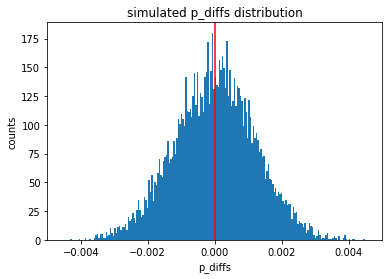

In [33]:
plt.hist(p_diffs, bins=200)
plt.xlim(-0.005, 0.005)
plt.xlabel('p_diffs')
plt.ylabel('counts')
plt.title('simulated p_diffs distribution')
plt.axvline(0.000, color='red');

### Conclusion
This is what we expected. The center of p_diffs seem be at 0.000. In the simulation, pnew_null and pold_null are equal, so we would expect the center of p_diffs to be at 0.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [34]:
actual_diff=actual_pnew-actual_pold
actual_diff, actual_pnew, actual_pold

(-0.0015782389853555567, 0.11880806551510564, 0.1203863045004612)

In [35]:
actual_diff=actual_pnew-actual_pold
(p_diffs>actual_diff).mean()

0.9021

k. Let's explain using the vocabulary we've learned in this Project what we just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Conclusion Part II **
- What we calculated in part j is the p value. The value 0.90 is much larger than alpha 0.05. Therefore we failed to reject null, and new page is not better in leading to conversion than old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [36]:
import statsmodels.api as sm

convert_old = (df2.query('landing_page=="old_page"')['converted']==1).sum()
convert_new = (df2.query('landing_page=="new_page"')['converted']==1).sum()
n_old = (df2['landing_page']=='old_page').sum()
n_new=(df2['landing_page']=='new_page').sum()

convert_old, convert_new, n_old, n_new    

(17489, 17264, 145274, 145310)

m. Now let's use `stats.proportions_ztest` to compute our test statistic and p-value. 

In [37]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [38]:
from scipy.stats import norm
# Tells us how significant our z-score is
print(norm.cdf(z_score))

# for our single-sides test, assumed at 95% confidence level, we calculate: 
print(norm.ppf(1-(0.05)))

0.09494168724097551
1.6448536269514722


n. What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Conclusion**
- zscore is 1.31, less than the critical value 1.64. P value is 0.9, larger than alpha 0.05. Therefore based on z-score and p value we fail to reject null, which is **$p{old} ∗∗−∗∗ p{new} ∗∗>=0∗∗.∗∗ p{new}

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should we be performing in this case?

**Logistic Regresion!!**
- For all the categorical variable we must use Logistic regression by adding appropriate dummy variables.


b. Our goal is to use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, our first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. Let's add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control** group.

In [39]:
df2['intercept']=1
df2['ab_page']=pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Let's **statsmodels** to instantiate our regression model on the two columns we created in part b., then fit the model using the two columns we created in part **b.** to predict whether or not an individual converts. 

In [40]:
lm=sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results=lm.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 19 Mar 2020   Pseudo R-squ.:               8.077e-06
Time:                        16:17:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Let's provide a summary of our model below, and use it as necessary to help us with the following questions we would have.

In [41]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

e. What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with our regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Conclusion Part III**
-  The p value is 0.19.
This is different from results in Part II because the null hypothesis is different. In Part II, null=new page is not better than old page, alternative=new page is better. So Part II is a one-sided test. Here, we hope to find out that conversion depends on which landing page users use. The alternative here is that conversion rates are different, and null is there is no difference. So this is a two-sided test

f. Now, we are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into our regression model?

**Conclusion Part III**

- We will be better predicting response if other factors are considered. One disadvantage of including other factors is that explanatory variables might dependent on each other. Some predictors might lose significance, or result in even flipped coefficients

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We will need to read in the **countries.csv** dataset and merge together our datasets on the appropriate rows. 

Does it appear that country had an impact on conversion?  We can't forget to create dummy variables for these country columns - **Hint: We will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [42]:
# read in the country table
country=pd.read_csv('countries.csv')

In [43]:
# Merging country and df2 tables
df2=pd.merge(df2, country, on=['user_id'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [46]:
# create dummy columns for country
df2[['CA', 'UK','US']]=pd.get_dummies(df2['country'])
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1


In [47]:
lm=sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results=lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2020-03-19 16:25 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Let's provide the summary results, and our conclusions based on the results.

# Final conclusion

The summary above means that UK is 1.01 likely to be converted relativew to users in US, holding everything else constant.

The coefficientes obtained here are not so different from those obtained in previous sections. Therefore We have the conclusion that there is no effectss whether to include single or multiple variables.
The Variables ab_page and country seem to be independent on each other.

The P value for CA and UK are larger, so we don't need to consider the results are statistically significant.

# REFERENCES

Statsmodels - Proportions ztest
https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/

Udacity
https://www.udacity.com/courses/all

Pandas - Documentation
https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html#getting-started

Pandas - Joining Tables
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html



